# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import joblib

import warnings
warnings.filterwarnings('ignore')

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Exploration des données

## Fonctions

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df_train = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\application_train.csv', nrows= num_rows)
    df_test = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df_train), len(df_test)))
        
    df_train = df_train.append(df_test).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df_train = df_train[df_train['CODE_GENDER'] != 'XNA']    
    df_train = df_train[df_train['NAME_FAMILY_STATUS'] != 'Unknown']
    df_train = df_train[df_train['NAME_INCOME_TYPE'] != 'Maternity leave']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df_train[bin_feature], uniques = pd.factorize(df_train[bin_feature])
    # Categorical features with One-Hot encode
    df_train, cat_cols = one_hot_encoder(df_train, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df_train['DAYS_EMPLOYED_PERC'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']
    df_train['INCOME_CREDIT_PERC'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
    df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / df_train['CNT_FAM_MEMBERS']
    df_train['ANNUITY_INCOME_PERC'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
    df_train['PAYMENT_RATE'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']   
    
    df_train['AMT_CREDIT_GOODS'] = df_train['AMT_CREDIT'] / df_train['AMT_GOODS_PRICE']
    df_train['SOURCES_MEAN'] = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    del df_test
    gc.collect()
    return df_train

In [4]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = False):
    bureau = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\bureau.csv', nrows = num_rows)
    bb = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\bureau_balance.csv', nrows = num_rows)
          
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [5]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = False):
    prev = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\previous_application.csv', nrows = num_rows)  

    prev, cat_cols = one_hot_encoder(prev, nan_as_category= False)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = False):
    pos = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\POS_CASH_balance.csv', nrows = num_rows)
    
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= False)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = False):
    ins = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\installments_payments.csv', nrows = num_rows)
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= False)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = False):
    cc = pd.read_csv('D:\\Formation\\DataScientist\\Projet7\\data\\credit_card_balance.csv', nrows = num_rows)     
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= False)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [9]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
import re
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        train_x = train_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        #train_y = train_y.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        valid_x = valid_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        #valid_y = valid_y.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )        
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        #test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [10]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [11]:
def main(debug = False):
    num_rows = 10000 if debug else None
    with timer("Process train and test"):
        df = application_train_test(num_rows)
        gc.collect()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    return df

In [12]:
if __name__ == "__main__":
    with timer("Dataframe merge run"):
        dfData = main()

Train samples: 307511, test samples: 48744
Process train and test - done in 6s
Bureau df shape: (305811, 112)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 233)
Process previous_applications - done in 30s
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 37s
Credit card balance df shape: (103558, 136)
Process credit card balance - done in 26s
Dataframe merge run - done in 134s


In [13]:
#Echantillon de données
dfData_echantillon = dfData.sample(10000)
    
with timer("Run LightGBM with kfold"):
    feat_importance_lightgbm = kfold_lightgbm(dfData_echantillon, num_folds= 10, stratified= True)

Starting LightGBM. Train shape: (8651, 772), test shape: (1349, 772)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.874042	training's binary_logloss: 0.212874	valid_1's auc: 0.717265	valid_1's binary_logloss: 0.260915
[400]	training's auc: 0.927224	training's binary_logloss: 0.183157	valid_1's auc: 0.727044	valid_1's binary_logloss: 0.259444
Fold  1 AUC : 0.726247
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.878849	training's binary_logloss: 0.211658	valid_1's auc: 0.7092	valid_1's binary_logloss: 0.260912
[400]	training's auc: 0.932149	training's binary_logloss: 0.181349	valid_1's auc: 0.710332	valid_1's binary_logloss: 0.262727
Fold  2 AUC : 0.710620
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.878235	training's bi

In [14]:
dfData.shape

(356244, 772)

## Analyse de l'âge du client

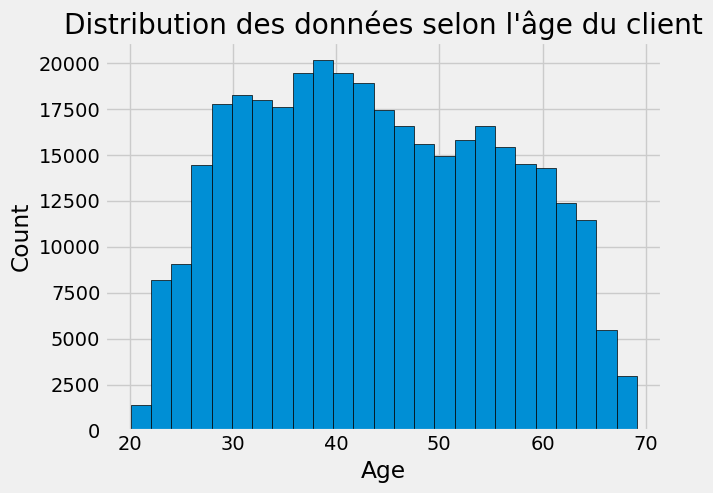

In [15]:
# Distribution des données selon l'âge du client
plt.style.use('fivethirtyeight')
plt.hist(abs(dfData['DAYS_BIRTH']) / 365, edgecolor = 'k', bins = 25)
plt.title('Distribution des données selon l\'âge du client'); plt.xlabel('Age'); plt.ylabel('Count');

In [16]:
# Créer in dataframe pour gérer les tranches d'âge
age_data = dfData[['TARGET', 'DAYS_BIRTH']]
age_data['DAYS_BIRTH'] = abs(age_data['DAYS_BIRTH'])
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0     1.0        9461    25.920548  (25.0, 30.0]
1     0.0       16765    45.931507  (45.0, 50.0]
2     0.0       19046    52.180822  (50.0, 55.0]
3     0.0       19005    52.068493  (50.0, 55.0]
4     0.0       19932    54.608219  (50.0, 55.0]
5     0.0       16941    46.413699  (45.0, 50.0]
6     0.0       13778    37.747945  (35.0, 40.0]
7     0.0       18850    51.643836  (50.0, 55.0]
8     0.0       20099    55.065753  (55.0, 60.0]
9     0.0       14469    39.641096  (35.0, 40.0]

In [17]:
# Regrouper par tranches et calculer les moyennes
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8538.378305    23.392817
(25.0, 30.0]  0.111446  10158.570896    27.831701
(30.0, 35.0]  0.102817  11856.366609    32.483196
(35.0, 40.0]  0.089376  13708.106478    37.556456
(40.0, 45.0]  0.078493  15497.607877    42.459200
(45.0, 50.0]  0.074171  17323.579317    47.461861
(50.0, 55.0]  0.066968  19193.920120    52.586083
(55.0, 60.0]  0.055316  20982.126230    57.485277
(60.0, 65.0]  0.052739  22779.736648    62.410237
(65.0, 70.0]  0.037270  24287.482457    66.541048

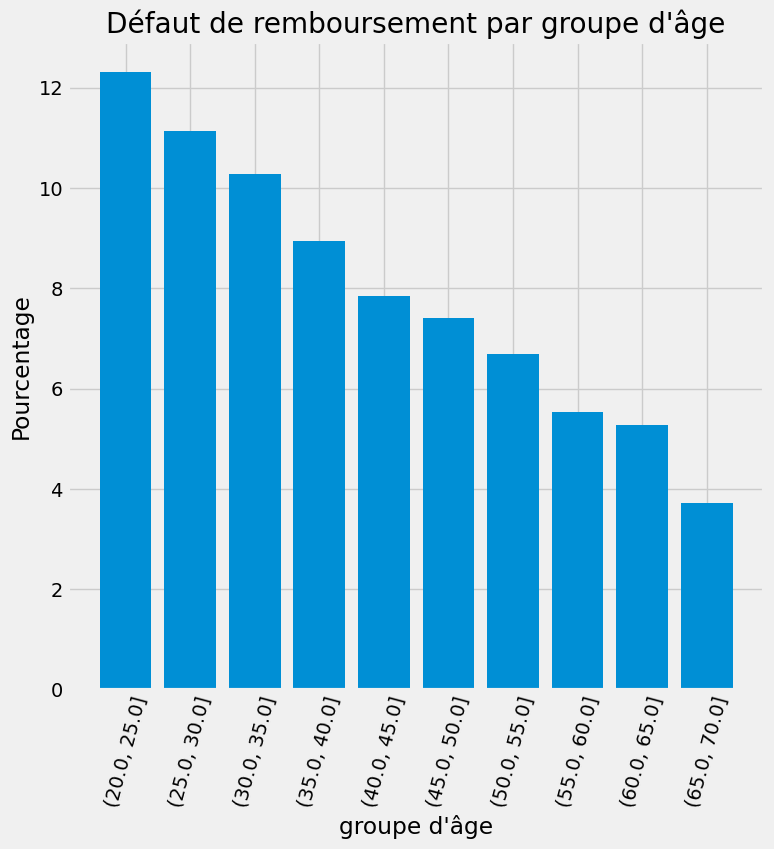

In [18]:
# Représentez graphiquement les tranches d'âge et la moyenne de la cible
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('groupe d\'âge'); plt.ylabel('Pourcentage')
plt.title('Défaut de remboursement par groupe d\'âge');

# Pré-Traitement

## Preprocessing + Echantillonage des données

In [19]:
# Fonction pour la génération de X_train, X_test, y_train, y_test
def echantillonage(df_X, df_y):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [20]:
dddd = dfData.copy()

In [21]:
dfData.isna().sum().sum()

70162699

In [22]:
dfData = dddd.copy()

In [23]:
# Imputation par la medianne des valeurs NaN des colonnes numériques
for col in dfData.describe().columns:
    dfData[col]=dfData[col].fillna((dfData[col].median()))

In [24]:
dfData_no_nan = dfData.copy()

In [25]:
X_cols = [col for col in dfData.columns if col != 'TARGET']
y_col =['SK_ID_CURR', 'TARGET']

X1 = dfData[X_cols].set_index('SK_ID_CURR')
X2 = dfData[y_col].set_index('SK_ID_CURR')

In [26]:
from sklearn.model_selection import train_test_split

print("Echantillonage : train = 80% | test = 20%")
X_train, X_test, y_train, y_test = echantillonage(X1, X2)

Echantillonage : train = 80% | test = 20%


In [27]:
print('X_train = ', X_train.shape)
print('X_test = ', X_test.shape)
print('y_train = ', y_train.shape)
print('y_test = ', y_test.shape)

X_train =  (284995, 770)
X_test =  (71249, 770)
y_train =  (284995, 1)
y_test =  (71249, 1)


In [28]:
X_train.drop('index', axis = 1, inplace = True)
X_test.drop('index', axis = 1, inplace = True)

In [29]:
X_train_saved = X_train.copy()
X_test_saved = X_test.copy()

In [30]:
# Exporter jeux Train/Test
joblib.dump(X_test, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_test_init.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_test_init.joblib']

In [31]:
X_Target = pd.DataFrame()
X_Target['TARGET'] = dfData['TARGET']
X_Target

TARGET
0          1.0
1          0.0
2          0.0
3          0.0
4          0.0
...        ...
356250     0.0
356251     0.0
356252     0.0
356253     0.0
356254     0.0

[356244 rows x 1 columns]

In [32]:
# Exporter Target
joblib.dump(X_Target, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_Target.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_Target.joblib']

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)
imputer.fit(X_test)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [34]:
# Exporter jeux Train/Test
joblib.dump(X_test, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_test.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\X_test.joblib']

## Analyse de la Baseline

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
    
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Predictions
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# On enregistre les résultats
df_pred_lr = pd.DataFrame(log_reg_pred, columns=['y_pred_lr'], index=y_test.index)
df_results_base = pd.concat([df_results_base, df_pred_lr], sort=False, axis=1)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# On concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = (df_results_base["y_pred_lr"] >= 0.5).astype("int")

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 93.05%


y_true  y_pred_lr  y_pred_lr_bin
SK_ID_CURR                                  
119066         0.0   0.086012              0
242434         0.0   0.049654              0
264112         0.0   0.087450              0
253675         1.0   0.060787              0
306011         0.0   0.042396              0

(71249, 3)


Confusion matrix

In [36]:
def aff_confusion_matrix(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

Confusion matrix:
 [[66300     0]
 [ 4949     0]]


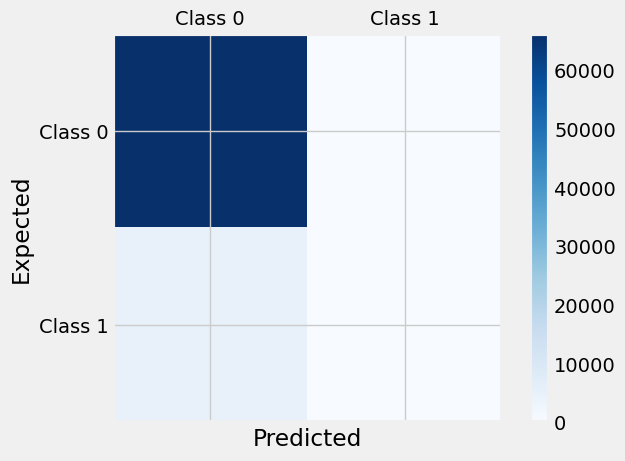

In [37]:
from sklearn.metrics import confusion_matrix
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

On remarque que l'accuracy du modèle est excellente, mais cela est dû au fait que le jeu de données est fortement déséquilibré.

In [38]:
# Affichage du résultat
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["feat_eng"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

df_metrics_base

Accuracy Precision Recall F1_score
feat_eng     0.93       0.0    0.0      0.0

## Resampling

Dans le cas de données très déséquilibré comme ici, il existe des techniques de rééchantillonage afin de rééquilibrer ces données.

Exemple : Un jeu de données de 1000 individus, avec 90% de target=0 et 10% de target=1.

Imaginons que le modèle ne prédise que des 0. Il aura une accuracy de 90% au général, mais pour la classe 1 son accuracy sera de 0%. Le modèle ne sera donc pas si performant que ça.

In [39]:
print("Etat des lieux : DESEQUILIBRAGE DES DONNEES")

percent0 = (y_train.value_counts()[0] / y_train.shape) * 100
percent1 = (y_train.value_counts()[1] / y_train.shape) * 100

print("Nombre d'individus pour la classe 0 :", y_train.value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", y_train.value_counts()[1], ". Soit", percent1, "% de la population.")

Etat des lieux : DESEQUILIBRAGE DES DONNEES
Nombre d'individus pour la classe 0 : 265121 . Soit [9.30265443e+01 2.65121000e+07] % de la population.
Nombre d'individus pour la classe 1 : 19874 . Soit [6.97345567e+00 1.98740000e+06] % de la population.


In [40]:
target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

Class 0: 265121
Class 1: 19874
Proportion: 13.34 : 1


([<matplotlib.patches.Wedge at 0x2581ca873a0>,
 [Text(-0.23906232392624763, -1.0737081564740867, 'Classe 0'),
  Text(0.2607953172983491, 1.1713179766721133, 'Classe 1')],
 [Text(-0.1303976312324987, -0.5856589944404109, '93.0%'),
  Text(0.1521306017573703, 0.6832688197253994, '7.0%')])

On va utiliser la bibliothèque Python "balanced-learn". Elle est compatible avec scikit-learn.

In [41]:
%%time

import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter

print("Resampling")
smt = RandomUnderSampler()
X_smt, y_smt = smt.fit_resample(X_train, y_train)

print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_smt))

Resampling
Original dataset shape Counter({'TARGET': 1})
Resampled dataset shape Counter({'TARGET': 1})
CPU times: total: 1.61 s
Wall time: 1.79 s


Class 0: 19874
Class 1: 19874
Proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x2581d7705e0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'Classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

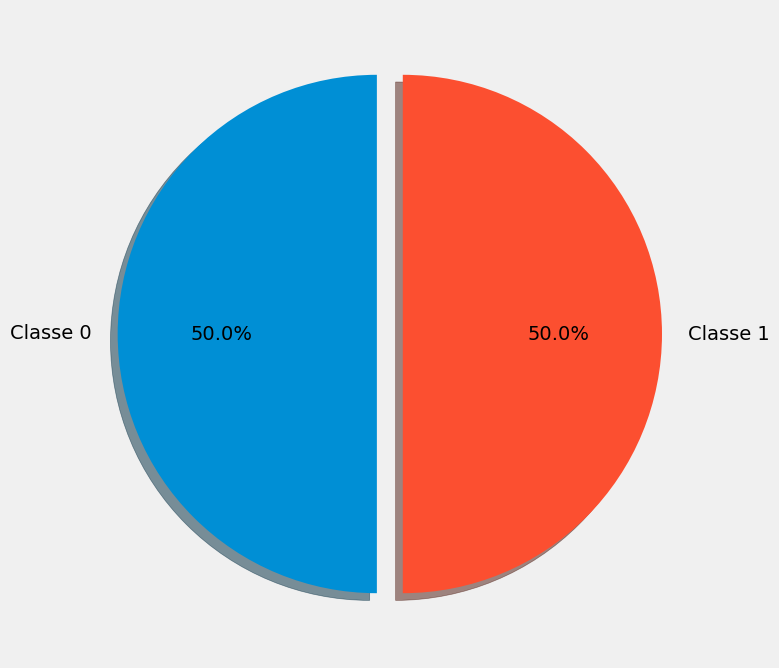

In [42]:
# Afficher la répartition des données Target après optimisation
target_count = y_smt.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

In [43]:
# Analyse de la baseline après optimisation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_smt, y_smt)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
    
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# On enregistre les résultats
df_pred_lr = pd.DataFrame(log_reg_pred, columns=['y_pred_lr'], index=y_test.index)
df_results_base = pd.concat([df_results_base, df_pred_lr], sort=False, axis=1)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = (df_results_base["y_pred_lr"] >= 0.5).astype("int")

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 66.79%


y_true  y_pred_lr  y_pred_lr_bin
SK_ID_CURR                                  
119066         0.0   0.530814              1
242434         0.0   0.426525              0
264112         0.0   0.533071              1
253675         1.0   0.464115              0
306011         0.0   0.395967              0

(71249, 3)


Confusion matrix:
 [[44366 21934]
 [ 1725  3224]]


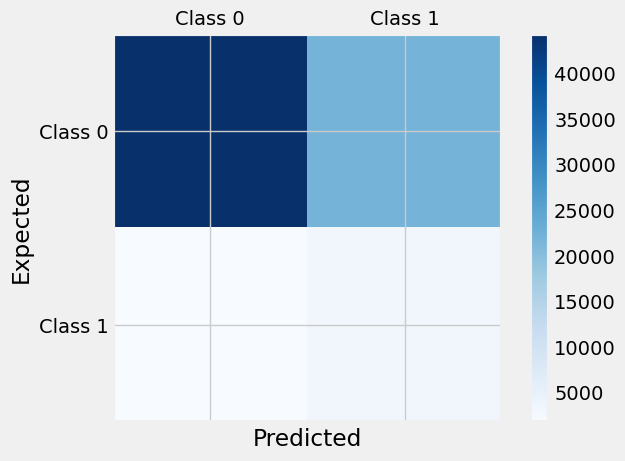

In [44]:
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

In [45]:
# Afficher le résultat
df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["feat_eng"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

df_metrics_base

Accuracy Precision Recall F1_score
feat_eng     0.67      0.13   0.65     0.21

# Modélisation

Nous allons entraîner plusieurs modèles et choisir le plus performant.
Nous allons mesurer à chaque fois :

le taux de TP, TN, FP, FN
la précision
le recall
le Fi
l'accuracy

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [47]:
# Préparer un dataframe pour contenir les résultats
df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

In [48]:
dtest = dfData.copy()

In [49]:
dtest.drop(['SK_ID_CURR', 'TARGET'], axis= 1, inplace = True)

## Régression logistique

In [50]:
# Make the model with the specified regularization parameter
clf_lr = LogisticRegression(C=10)

# Train on the training data
clf_lr.fit(X_smt, y_smt)

# Make predictions
# Make sure to select the second column only
lr_pred_smoted = clf_lr.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_lr_smoted"] = lr_pred_smoted

df_results.head()

y_true  y_pred_lr_smoted
SK_ID_CURR                          
119066         0.0          0.558668
242434         0.0          0.248854
264112         0.0          0.447796
253675         1.0          0.518907
306011         0.0          0.118032

In [51]:
df_results["y_pred_lr_smoted_bin"] = (df_results["y_pred_lr_smoted"] >= 0.5).astype("int")
df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin
SK_ID_CURR                                                
119066         0.0          0.558668                     1
242434         0.0          0.248854                     0
264112         0.0          0.447796                     0
253675         1.0          0.518907                     1
306011         0.0          0.118032                     0

In [52]:
dtest.drop('index', axis = 1, inplace = True)

In [53]:
# Make the feature importance dataframe
feature_importances_lr = pd.DataFrame({'feature': dtest.columns, 'importance': clf_lr.coef_[0]})
   
# Sort features according to importance
feature_importances_lr = feature_importances_lr.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances_lr['importance_normalized'] = feature_importances_lr['importance'] / feature_importances_lr['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_lr.index[:15]))),
        feature_importances_lr['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_lr.index[:15]))))
ax.set_yticklabels(feature_importances_lr['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Logistic regression (Feature Importances)')
plt.show()

## Random Forest

In [54]:
%%time

# Make the model with the specified regularization parameter
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth=10)

# Train on the training data
clf_rf.fit(X_smt, y_smt)

# Make predictions
# Make sure to select the second column only
rf_pred_smoted = clf_rf.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_rf_smoted"] = rf_pred_smoted

df_results.head()

CPU times: total: 3min 26s
Wall time: 3min 27s


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted
SK_ID_CURR                                                                  
119066         0.0          0.558668                     1          0.497185
242434         0.0          0.248854                     0          0.390752
264112         0.0          0.447796                     0          0.462396
253675         1.0          0.518907                     1          0.518785
306011         0.0          0.118032                     0          0.349997

In [55]:
df_results["y_pred_rf_smoted_bin"] = (df_results["y_pred_rf_smoted"] >= 0.5).astype("int")
df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   

            y_pred_rf_smoted_bin  
SK_ID_CURR                        
119066                         0  
242434                         0  
264112                         0  
253675                         1  
306011                         0

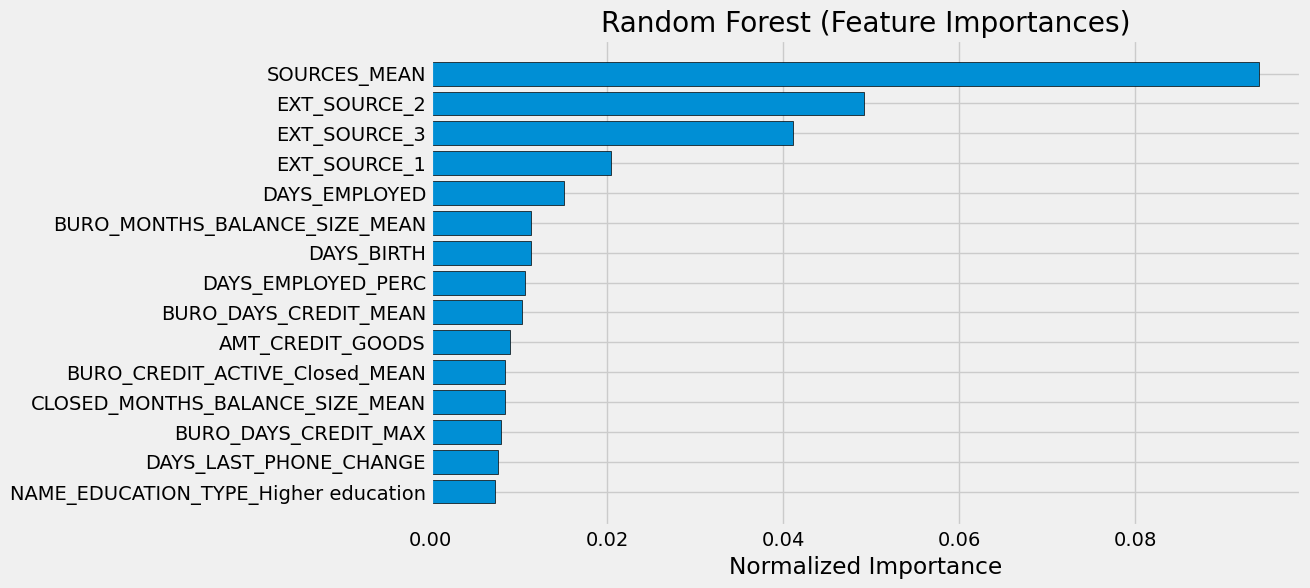

In [56]:
# Make the feature importance dataframe
feature_importances_rf = pd.DataFrame({'feature': dtest.columns, 'importance': clf_rf.feature_importances_})
   
# Sort features according to importance
feature_importances_rf = feature_importances_rf.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances_rf['importance_normalized'] = feature_importances_rf['importance'] / feature_importances_rf['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_rf.index[:15]))),
        feature_importances_rf['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_rf.index[:15]))))
ax.set_yticklabels(feature_importances_rf['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Random Forest (Feature Importances)')
plt.show()

## Gradient Boosting Classifier

In [57]:
%%time

# Create the model
clf_lgb = lgb.LGBMClassifier(n_estimators=10000,
                             objective='binary',
                             class_weight='balanced',
                             learning_rate=0.05,
                             reg_alpha=0.1,
                             reg_lambda=0.1,
                             subsample=0.8,
                             n_jobs=-1,
                             random_state=0
                            )

# Train on the training data
clf_lgb.fit(X_smt, y_smt)

# Make predictions
# Make sure to select the second column only
lgb_pred_smoted = clf_lgb.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted
    
df_results.head()

CPU times: total: 1h 18min 9s
Wall time: 11min 4s


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   

            y_pred_rf_smoted_bin  y_pred_lgb_smoted  
SK_ID_CURR                                           
119066                         0           0.772588  
242434                         0           0.639757  
264112                         0           0.114772  
253675                         1           0.950662  
306011                         0           0.013689

In [58]:
df_results["y_pred_lgb_smoted_bin"] = (df_results["y_pred_lgb_smoted"] >= 0.5).astype("int")

df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   

            y_pred_rf_smoted_bin  y_pred_lgb_smoted  y_pred_lgb_smoted_bin  
SK_ID_CURR                                                                  
119066                         0           0.772588                      1  
242434                         0           0.639757                      1  
264112                         0           0.114772                      0  
253675                         1           0.950662                      1  
306011                         0           0.013689                      0

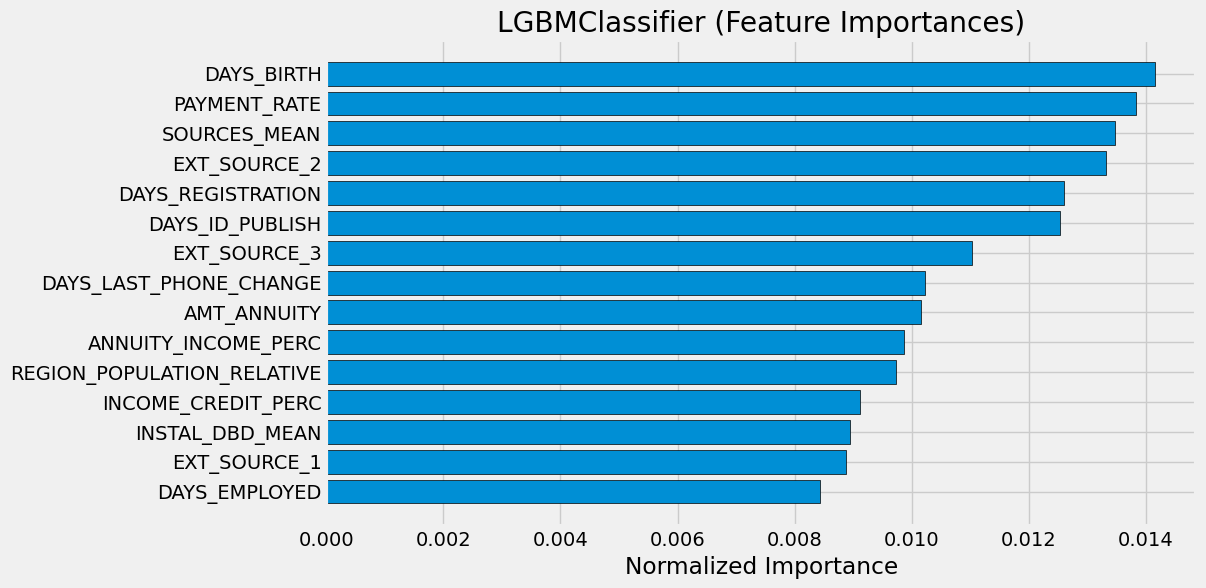

In [59]:
# Make the feature importance dataframe
feature_importances_lgb = pd.DataFrame({'feature': dtest.columns, 'importance': clf_lgb.feature_importances_})
   
# Sort features according to importance
feature_importances_lgb = feature_importances_lgb.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances_lgb['importance_normalized'] = feature_importances_lgb['importance'] / feature_importances_lgb['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_lgb.index[:15]))),
        feature_importances_lgb['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_lgb.index[:15]))))
ax.set_yticklabels(feature_importances_lgb['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('LGBMClassifier (Feature Importances)')
plt.show()

## XGBoost

In [60]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=0)
clf_xgb.fit(X_smt, y_smt)

# Make predictions
# Make sure to select the second column only
xgb_pred_smoted = clf_xgb.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_xgb_smoted"] = xgb_pred_smoted    
df_results.head()

[21:43:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   

            y_pred_rf_smoted_bin  y_pred_lgb_smoted  y_pred_lgb_smoted_bin  \
SK_ID_CURR                                                                   
119066                         0           0.772588                      1   
242434                         0           0.639757                      1   
264112                         0           0.114772                      0   
253675                         1           0.950662                      1   
306011                         0           0.013689                      0   

            y_pred_xgb_smoted  
SK_ID_CURR                     
119066               0.509020  
242434               0.403695  
264112               0.572796  
253675               0.804316  
306011               0.601437

In [61]:
df_results["y_pred_xgb_smoted_bin"] = (df_results["y_pred_xgb_smoted"] >= 0.5).astype("int")
df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   

            y_pred_rf_smoted_bin  y_pred_lgb_smoted  y_pred_lgb_smoted_bin  \
SK_ID_CURR                                                                   
119066                         0           0.772588                      1   
242434                         0           0.639757                      1   
264112                         0           0.114772                      0   
253675                         1           0.950662                      1   
306011                         0           0.013689                      0   

            y_pred_xgb_smoted  y_pred_xgb_smoted_bin  
SK_ID_CURR                                            
119066               0.509020                      1  
242434               0.403695                      0  
264112               0.572796                      1  
253675               0.804316                      1  
306011               0.601437                      1

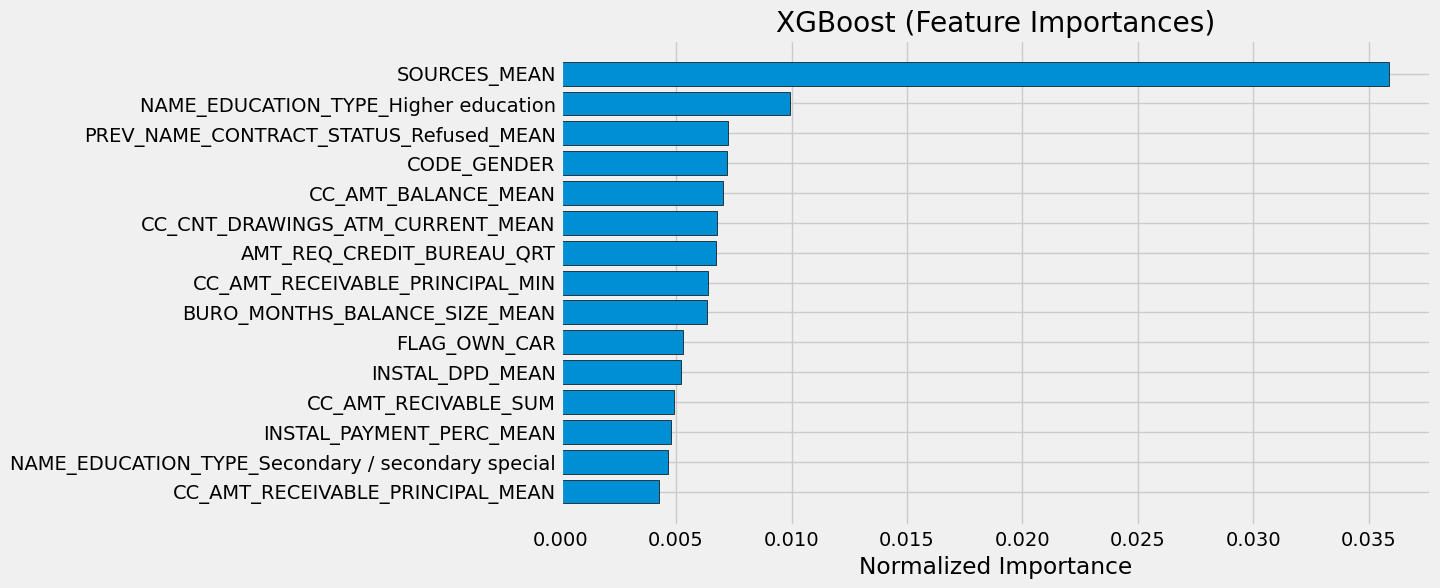

In [62]:
# Make the feature importance dataframe
feature_importances_xgb = pd.DataFrame({'feature': dtest.columns, 'importance': clf_xgb.feature_importances_})
   
# Sort features according to importance
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances_xgb['importance_normalized'] = feature_importances_xgb['importance'] / feature_importances_xgb['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_xgb.index[:15]))),
        feature_importances_xgb['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_xgb.index[:15]))))
ax.set_yticklabels(feature_importances_xgb['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('XGBoost (Feature Importances)')
plt.show()

## Analyse des résultats

### Matrice de confusion

Matrice confusion régression logistique
Confusion matrix:
 [[47376 18924]
 [ 1505  3444]]


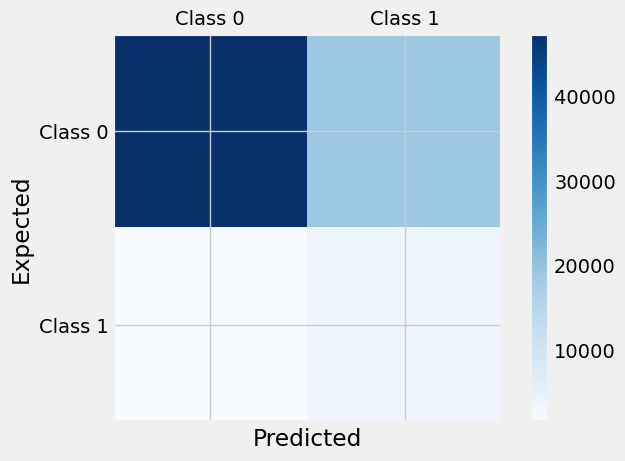

Matrice confusion random forest
Confusion matrix:
 [[48122 18178]
 [ 1631  3318]]


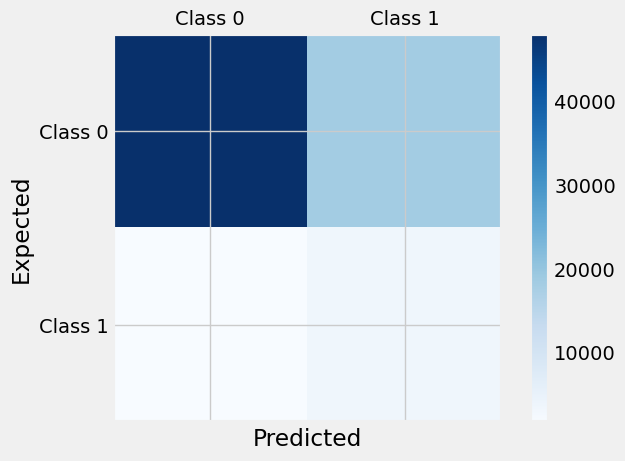

Matrice confusion LGBMClassifier
Confusion matrix:
 [[40930 25370]
 [ 1054  3895]]


Matrice confusion XGBoost
Confusion matrix:
 [[34995 31305]
 [  973  3976]]


In [63]:
print("Matrice confusion régression logistique")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_lr_smoted_bin"])

print("Matrice confusion random forest")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_rf_smoted_bin"])

print("Matrice confusion LGBMClassifier")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_lgb_smoted_bin"])

print("Matrice confusion XGBoost")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_xgb_smoted_bin"])

### Accuracy, Precision, Recall, F1 score

Nous allons mesurer différentes métriques pour bine comprendre les classifieurs :

- L'accuracy : Nous avons vu ici que l'accuracy ne signifait pas grand chose.
- La précision : Ce coefficient détermine que, quand le classifieur déclare que la prédiction est un 1, il a raison à X%.
- Le rappel : Ce coefficient détermine le pourcentage de détection des 1 du classifieur.
- Le F1-score : Ce coefficient est une moyenne de la précision et du rappel, mais, de part sa formule il donne plus de poids aux faibles valeurs.

In [64]:
df_results

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
SK_ID_CURR                                                                     
119066         0.0          0.558668                     1          0.497185   
242434         0.0          0.248854                     0          0.390752   
264112         0.0          0.447796                     0          0.462396   
253675         1.0          0.518907                     1          0.518785   
306011         0.0          0.118032                     0          0.349997   
...            ...               ...                   ...               ...   
423870         0.0          0.795455                     1          0.604687   
235503         0.0          0.153949                     0          0.436659   
178733         0.0          0.380615                     0          0.486322   
249326         0.0          0.190959                     0          0.311237   
412517         0.0          0.304055                     0          0.387170   

            y_pred_rf_smoted_bin  y_pred_lgb_smoted  y_pred_lgb_smoted_bin  \
SK_ID_CURR                                                                   
119066                         0           0.772588                      1   
242434                         0           0.639757                      1   
264112                         0           0.114772                      0   
253675                         1           0.950662                      1   
306011                         0           0.013689                      0   
...                          ...                ...                    ...   
423870                         1           0.426991                      0   
235503                         0           0.124460                      0   
178733                         0           0.047569                      0   
249326                         0           0.010833                      0   
412517                         0           0.221087                      0   

            y_pred_xgb_smoted  y_pred_xgb_smoted_bin  
SK_ID_CURR                                            
119066               0.509020                      1  
242434               0.403695                      0  
264112               0.572796                      1  
253675               0.804316                      1  
306011               0.601437                      1  
...                       ...                    ...  
423870               0.828386                      1  
235503               0.417354                      0  
178733               0.138725                      0  
249326               0.262033                      0  
412517               0.457755                      0  

[71249 rows x 9 columns]

In [65]:
round(accuracy_score(df_results["y_true"], df_results.iloc[:, 6]), 2)

0.63

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

nb_models = 4

df_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["Logistic regression", "Random Forest", "LGBMClassifier", "XGBoost"])

# j=2 représente la 3eme colonne du dataframe df_results
# on cible les colonnes de valeurs prédites avec cette variable
j = 2

for i in np.arange(0, nb_models):
    
    df_metrics["Accuracy"][i] = round(accuracy_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Precision"][i] = round(precision_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Recall"][i] = round(recall_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["F1_score"][i] = round(f1_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    
    j += 2

df_metrics

Accuracy Precision Recall F1_score
Logistic regression     0.71      0.15    0.7     0.25
Random Forest           0.72      0.15   0.67     0.25
LGBMClassifier          0.63      0.13   0.79     0.23
XGBoost                 0.55      0.11    0.8      0.2

### Courbe Receiver Operating

In [67]:
from sklearn.metrics import roc_curve

fp_lr, tp_lr, treshold_lr = roc_curve(y_test, lr_pred_smoted)
fp_rf, tp_rf, treshold_rf = roc_curve(y_test, rf_pred_smoted)
fp_lgb, tp_lgb, treshold_lgb = roc_curve(y_test, lgb_pred_smoted)
fp_xgb, tp_xgb, treshold_xgb = roc_curve(y_test, xgb_pred_smoted)

In [68]:
plt.figure(figsize=(20,10))

plt.plot(fp_lr, tp_lr, label="Logistic Regression")
plt.plot(fp_rf, tp_rf, label="Random Forest")
plt.plot(fp_lgb, tp_lgb, label="LGBMClassifier")
plt.plot(fp_xgb, tp_xgb, label="XGBoost")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

### Area Under the Curve (AUC)

Le score AUC est une façon de comparer des classificateurs. Un classificateur parfait aurait une aire sous la courbe ROC égale à 1, tandis qu'un classificateur purement aléatoire aurait une ROC AUC de 0.5.

In [69]:
from sklearn.metrics import roc_auc_score

auc_score_lr = roc_auc_score(y_test, lr_pred_smoted)
auc_score_rf = roc_auc_score(y_test, rf_pred_smoted)
auc_score_lgb = roc_auc_score(y_test, lgb_pred_smoted)
auc_score_xgb = roc_auc_score(y_test, xgb_pred_smoted)

lst_auc_score = [("Logistic Regression", auc_score_lr),
                ("Random Forest", auc_score_rf),
                ("LGBMClassifier", auc_score_lgb),
                ("XGBoost", auc_score_xgb)]

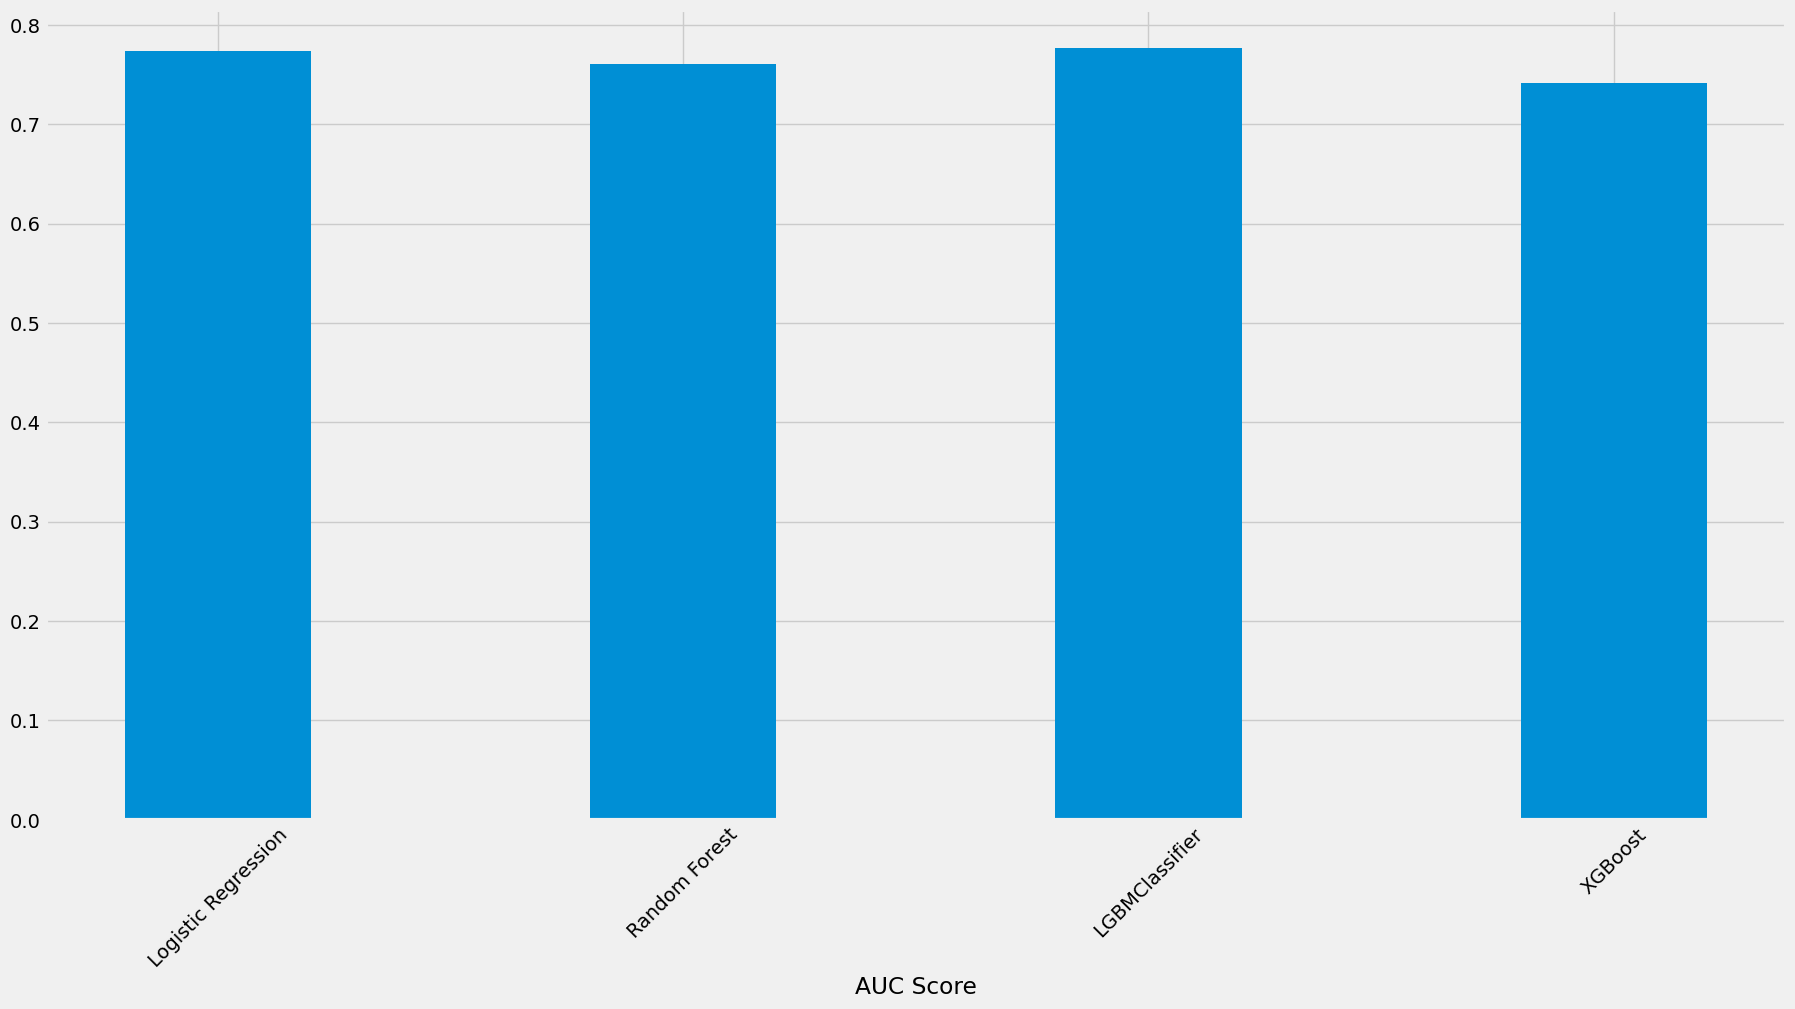

In [70]:
plt.figure(figsize=(20,10))

plt.style.use('fivethirtyeight')
labels, ys = zip(*lst_auc_score)
xs = np.arange(len(labels)) 
width = 0.4
plt.bar(xs, ys, width, align='center')
plt.xlabel("AUC Score")
plt.xticks(xs, labels, rotation=45)
plt.show()

Les modèles Random Forest est LGBMClassifier donnent les mêmes résultats. on va choisir le modèle Random Forest.

## Optimisation

In [71]:
X_train.shape

(284995, 769)

In [72]:
y_train.shape

(284995, 1)

In [73]:
## Echantillon de 10000 lignes
split = 20000
X_train_reduce = X_train[0:split,:]
y_train_reduce = y_train[0:split]

In [74]:
X_train_reduce.shape

(20000, 769)

In [75]:
y_train_reduce.shape

(20000, 1)

In [76]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators' : [10,50,100,300], #nombre d'arbres de décision
    'min_samples_leaf' : [1,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre=4,
}

rfr_search = GridSearchCV(RandomForestClassifier(),
                             param_grid = parameters,
                             verbose=1,
                             cv=5)

rfr_search.fit(y_train_reduce, y_train_reduce)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 50, 100, 300]},
             verbose=1)

In [77]:
rfr_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 10}

In [78]:
%%time

# Make the model with the specified regularization parameter
clf_rf_final = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 1, n_estimators = 10)

# Train on the training data
clf_rf_final.fit(X_train, y_train)

CPU times: total: 41 s
Wall time: 41 s


RandomForestClassifier(n_estimators=10)

In [79]:
prediction = clf_rf_final.predict_proba(X_test)

In [80]:
dfPrediction = pd.DataFrame()
dfPrediction['SK_ID_CURR'] = X_test_saved.index
dfPrediction['SCORE_0'] = clf_rf_final.predict_proba(X_test)[:, 0]
dfPrediction['SCORE_1'] = clf_rf_final.predict_proba(X_test)[:, 1]

In [81]:
dfPrediction

SK_ID_CURR  SCORE_0  SCORE_1
0          119066      0.7      0.3
1          242434      0.8      0.2
2          264112      0.8      0.2
3          253675      0.8      0.2
4          306011      0.6      0.4
...           ...      ...      ...
71244      423870      0.6      0.4
71245      235503      0.8      0.2
71246      178733      1.0      0.0
71247      249326      0.6      0.4
71248      412517      0.7      0.3

[71249 rows x 3 columns]

In [82]:
# Export
joblib.dump(dfPrediction, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\dfPrediction.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\dfPrediction.joblib']

## Feature importance globale du modèle retenu (Random Forest)

In [83]:
features_and_importances = sorted(zip(dtest.columns,
                                      clf_rf_final.feature_importances_),
                                  key=lambda x: x[1],
                                  reverse=True)

<BarContainer object of 15 artists>

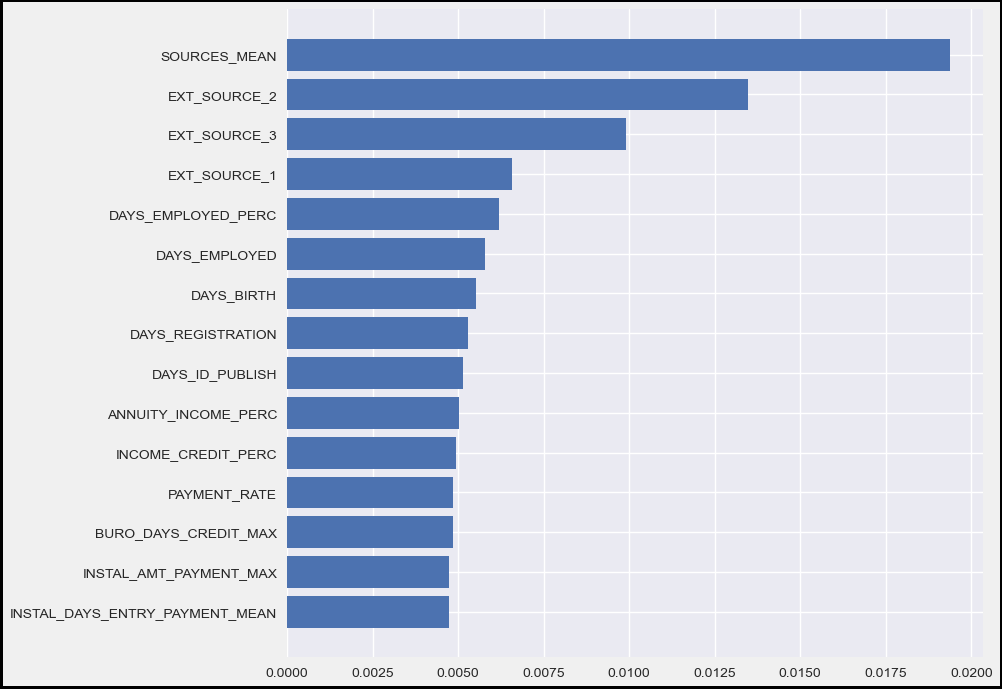

In [84]:
features_and_importances = np.array(features_and_importances)

plt.figure(figsize=(8, 8), edgecolor='black', linewidth=4)
plt.style.use('seaborn')
plt.barh(features_and_importances[:15, 0][::-1],
         features_and_importances[:15, 1][::-1].astype(float))

In [85]:
# Exporter les features importances globales
joblib.dump(features_and_importances, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\feature_importances.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\feature_importances.joblib']

## Feature importance locale avec LIME

In [86]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_test,
                                              feature_names=dtest.columns,
                                              #class_names=['Non Defaut', 'Default'],
                                              verbose=True, 
                                              mode='classification')

In [87]:
j = 5
exp = explainer.explain_instance(X_test[j], clf_rf_final.predict_proba, num_features=6)

Intercept 0.36842998494263535
Prediction_local [0.30256493]
Right: 0.2


In [88]:
# Show the predictions
exp.show_in_notebook(show_table=True)

In [89]:
# Export
joblib.dump(exp, 'C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\exp.joblib')

['C:\\Users\\adservio-benali\\Projet7\\livrable\\models\\exp.joblib']

In [90]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()

In [91]:
from IPython.display import HTML

html_data = exp.as_html()
HTML(data=html_data)

## Enregistrement du modèle mlflow

In [182]:
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline

In [183]:
pipeline = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('classification', ensemble.RandomForestClassifier(**rfr_search.best_params_))])

In [184]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classification', RandomForestClassifier(n_estimators=10))])

In [185]:
pipeline.score(X_test, y_test)

0.9084618731490969

In [187]:
joblib.dump(pipeline, 'D:\\Formation\\DataScientist\\Projet7\\pipeline_housing.joblib')

['D:\\Formation\\DataScientist\\Projet7\\pipeline_housing.joblib']

In [188]:
from mlflow.models.signature import infer_signature

In [189]:
signature = infer_signature(X_train, y_train)

In [190]:
import mlflow.sklearn

In [191]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)